Data: https://huggingface.co/datasets/Qdrant/NOAA-Buoy
Tutorial Credit: https://www.youtube.com/watch?v=c0k-YLQGKjY

# Single variable section

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [63]:
df = pd.read_csv('./full_years_remove_flawed_rows.csv')

In [64]:
df['timestamp'] = pd.to_datetime(df['TSTMP'])
df.set_index('timestamp', inplace=True)
df.drop(['TSTMP'], axis=1, inplace=True)
df

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP
timestamp,,,,,,,,,,,,,,,
1980-01-01 00:00:00-05:00,1980,1,1,0,0,323.0,10.6,14.3,1.80,5.90,5.10,NaN,1020.2,15.6,21.1
1980-01-01 01:00:00-05:00,1980,1,1,1,0,317.0,10.0,13.0,1.70,6.30,5.00,NaN,1020.7,15.6,21.1
1980-01-01 02:00:00-05:00,1980,1,1,2,0,323.0,9.4,12.3,1.80,6.30,4.90,NaN,1021.3,15.6,21.1
1980-01-01 03:00:00-05:00,1980,1,1,3,0,311.0,9.3,12.3,1.80,6.30,5.10,NaN,1021.8,15.7,21.2
1980-01-01 04:00:00-05:00,1980,1,1,4,0,324.0,8.2,10.9,1.80,6.70,5.20,NaN,1022.0,15.4,21.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:40:00-05:00,2022,12,31,21,40,82.0,2.3,3.3,1.27,8.33,6.18,101.0,1014.8,24.5,NaN
2022-12-31 22:10:00-05:00,2022,12,31,22,10,100.0,2.6,3.5,1.13,6.25,5.96,118.0,1014.9,24.5,NaN
2022-12-31 22:40:00-05:00,2022,12,31,22,40,110.0,3.2,4.5,1.22,7.69,6.19,100.0,1015.1,24.5,NaN


### This is a lot of data. Let's take periodic samples, every six hours

In [65]:
df = df[df.index.hour % 6 == 0]
df

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP
timestamp,,,,,,,,,,,,,,,
1980-01-01 00:00:00-05:00,1980,1,1,0,0,323.0,10.6,14.3,1.80,5.90,5.10,NaN,1020.2,15.6,21.1
1980-01-01 06:00:00-05:00,1980,1,1,6,0,339.0,8.1,10.3,1.60,6.70,5.10,NaN,1021.9,15.4,21.2
1980-01-01 12:00:00-05:00,1980,1,1,12,0,344.0,7.5,9.7,1.30,6.30,4.70,NaN,1020.7,15.4,21.1
1980-01-01 18:00:00-05:00,1980,1,1,18,0,352.0,5.3,7.6,1.10,5.90,4.80,NaN,1022.2,16.1,21.1
1980-01-02 00:00:00-05:00,1980,1,2,0,0,2.0,3.5,5.6,0.70,5.90,4.60,NaN,1020.0,15.7,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 06:40:00-05:00,2022,12,31,6,40,135.0,2.6,3.9,1.68,8.33,6.01,107.0,1014.5,24.6,NaN
2022-12-31 12:10:00-05:00,2022,12,31,12,10,259.0,3.4,5.0,1.57,7.69,6.19,115.0,1015.5,24.6,NaN
2022-12-31 12:40:00-05:00,2022,12,31,12,40,276.0,3.2,4.5,1.45,7.69,6.14,109.0,1015.8,24.6,NaN


## I dont want some of this data - it will not be useful

In [66]:
df = df.drop(['#YY', 'MM', 'DD', 'hh', 'mm', 'DPD', 'APD'], axis=1)
df

,WDIR,WSPD,GST,WVHT,MWD,PRES,ATMP,WTMP
timestamp,,,,,,,,
1980-01-01 00:00:00-05:00,323.0,10.6,14.3,1.80,NaN,1020.2,15.6,21.1
1980-01-01 06:00:00-05:00,339.0,8.1,10.3,1.60,NaN,1021.9,15.4,21.2
1980-01-01 12:00:00-05:00,344.0,7.5,9.7,1.30,NaN,1020.7,15.4,21.1
1980-01-01 18:00:00-05:00,352.0,5.3,7.6,1.10,NaN,1022.2,16.1,21.1
1980-01-02 00:00:00-05:00,2.0,3.5,5.6,0.70,NaN,1020.0,15.7,21.0
...,...,...,...,...,...,...,...,...
2022-12-31 06:40:00-05:00,135.0,2.6,3.9,1.68,107.0,1014.5,24.6,NaN
2022-12-31 12:10:00-05:00,259.0,3.4,5.0,1.57,115.0,1015.5,24.6,NaN
2022-12-31 12:40:00-05:00,276.0,3.2,4.5,1.45,109.0,1015.8,24.6,NaN


### I like to give some good names to the data and drop NA values. We can se how dropping the NA values drasticaally reduced our dataset

In [67]:
df.rename(columns={'WDIR': 'wind dir (deg)', 'WSPD': 'wind spd (m/s)', 'GST': 'wind gst (m/s)', 'WVHT': 'wave hgt (ft)', 'MWD': 'mean wave dir (deg)', 'PRES': 'air pres (ft)', 'ATMP': 'air temp (deg fah)', 'WTMP': 'water temp (deg fah)'}, inplace=True)
df = df.dropna()
df

,wind dir (deg),wind spd (m/s),wind gst (m/s),wave hgt (ft),mean wave dir (deg),air pres (ft),air temp (deg fah),water temp (deg fah)
timestamp,,,,,,,,
1994-08-17 18:00:00-05:00,185.0,6.0,7.6,0.50,168.0,1016.5,29.7,29.7
1994-08-18 00:00:00-05:00,325.0,0.7,1.3,0.60,128.0,1015.1,30.7,29.9
1994-08-18 06:00:00-05:00,132.0,7.1,8.8,0.80,73.0,1016.4,28.6,29.7
1994-08-18 12:00:00-05:00,180.0,6.0,7.1,1.10,153.0,1016.1,29.0,29.3
1995-02-01 06:00:00-05:00,159.0,4.6,6.1,0.40,17.0,1020.2,17.5,23.0
...,...,...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,8.0,6.4,9.9,1.51,18.0,1022.7,19.6,27.6
2022-10-20 06:40:00-05:00,9.0,4.0,6.6,1.07,56.0,1022.3,19.7,27.6
2022-10-20 12:40:00-05:00,11.0,3.9,6.2,0.93,63.0,1020.7,20.3,27.4


### Now we can see how various environmental factors affect the water behavior

### Let's start with a single variable prediction, then move onto multivariate predictions

In [68]:
#4 is equal to about a days worth of data - 4 six hour increments
def prediction(df, window=4):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range (len(df_as_np) - window):
        row = [[a] for a in df_as_np[i:i+window]]
        X.append(row)
        label = df_as_np[i+window]
        y.append(label)
    return np.array(X), np.array(y)


In [69]:
water_temp = df['water temp (deg fah)']
WINDOW_SIZE = 4
X1, y1 = prediction(water_temp, window=WINDOW_SIZE)
X1.shape, y1.shape



((28943, 4, 1), (28943,))

### Split the data into training, validation and test

In [70]:
X1_train, y1_train = X1[:int(0.7*len(X1))], y1[:int(0.7*len(y1))] #first 70 for train
X1_val, y1_val = X1[int(0.7*len(X1)):int(0.9*len(X1))], y1[int(0.7*len(y1)):int(0.9*len(y1))] #70 to 90 for validation
X1_test, y1_test = X1[int(0.9*len(X1)):], y1[int(0.9*len(y1)):] #last 10 for test

In [71]:
model1 = Sequential()
model1.add(InputLayer((4, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
cp1 = ModelCheckpoint('model1/model1.keras', save_best_only=True, verbose=0)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [73]:
model1.fit(X1_train, y1_train, epochs=10, validation_data=(X1_val, y1_val), callbacks=[cp1])

Epoch 1/10


634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 512.9715 - root_mean_squared_error: 22.5079 - val_loss: 56.7290 - val_root_mean_squared_error: 7.5287
Epoch 2/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 24.4107 - root_mean_squared_error: 4.8550 - val_loss: 8.7243 - val_root_mean_squared_error: 2.9522
Epoch 3/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.9493 - root_mean_squared_error: 2.6354 - val_loss: 5.3721 - val_root_mean_squared_error: 2.3165
Epoch 4/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.0119 - root_mean_squared_error: 2.0005 - val_loss: 2.3366 - val_root_mean_squared_error: 1.5275
Epoch 5/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3673 - root_mean_squared_error: 1.1626 - val_loss: 0.4864 - val_root_mean_squared_error: 0.6966
Epoch 6/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2758 - root_mean_squared_error: 0.5235 - val_loss: 0.1694 - val_root_mean_squared_error: 0.4112
Epoch 7/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss

In [74]:
model1 = load_model('model1/model1.keras')
train_preds1 = model1.predict(X1_train).flatten()
train_results1 = pd.DataFrame(data ={'Train Predictions': train_preds1, 'Actuals': y1_train})
train_results1

634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,Train Predictions,Actuals
0,29.571838,23.0
1,25.934557,22.8
2,23.693316,23.0
3,22.995813,23.0
4,23.020838,23.0
...,...,...
20255,23.018253,23.1
20256,23.082094,23.1
20257,23.127260,23.0
20258,23.093586,23.0


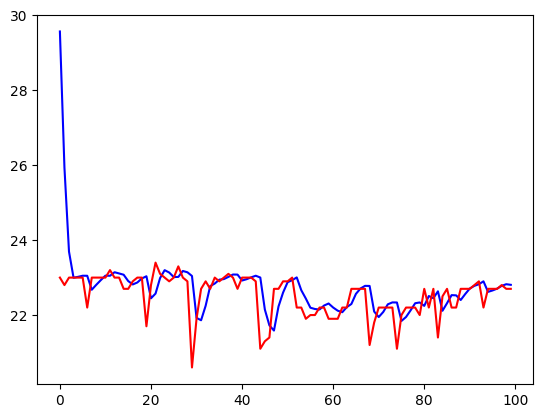

In [75]:
plt.plot(train_results1['Train Predictions'][:100], color='blue', label='Predictions')
plt.plot(train_results1['Actuals'][:100], color='red', label='Actuals')

In [76]:
val_preds1 = model1.predict(X1_val).flatten()
val_results1 = pd.DataFrame(data ={'Validation Predictions': val_preds1, 'Actuals': y1_val})
val_results1

  1/181 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Validation Predictions,Actuals
0,23.001471,22.9
1,22.971228,22.9
2,22.957354,22.9
3,22.957697,23.0
4,23.004704,23.0
...,...,...
5783,30.433197,30.6
5784,30.399254,30.6
5785,30.384899,30.8
5786,30.439711,30.6


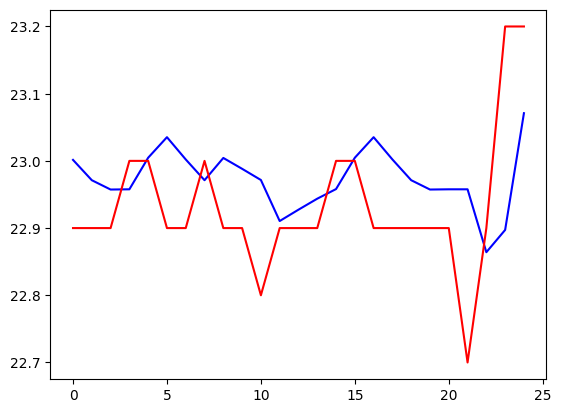

In [77]:
plt.plot(val_results1['Validation Predictions'][:25], color='blue')
plt.plot(val_results1['Actuals'][:25], color='red')

In [78]:
test_preds1 = model1.predict(X1_test).flatten()
test_results1 = pd.DataFrame(data ={'Test Predictions': test_preds1, 'Actuals': y1_test})
test_results1

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Test Predictions,Actuals
0,30.387518,30.5
1,30.347151,30.4
2,30.288420,30.2
3,30.182049,30.3
4,30.180773,30.2
...,...,...
2890,27.919279,27.6
2891,27.803427,27.6
2892,27.754187,27.4
2893,27.624258,27.4


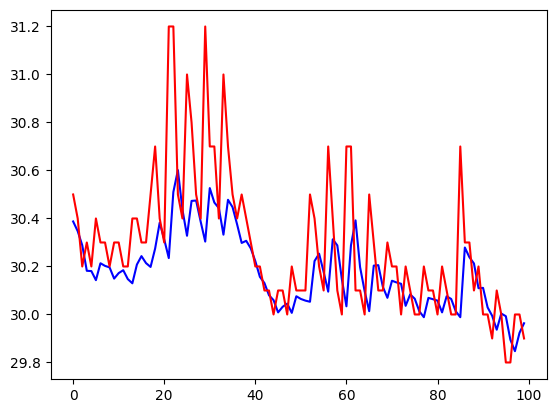

In [79]:
plt.plot(test_results1['Test Predictions'][:100], color='blue')
plt.plot(test_results1['Actuals'][:100], color='red')

In [80]:
def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data ={'Predictions': predictions, 'Actuals': y})
    plt.plot(df['Predictions'][start:end], color='blue', label='Predictions')
    plt.plot(df['Actuals'][start:end], color='red', label='Actuals')
    plt.legend()
    return df, mse(y, predictions)

 1/91 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(      Predictions  Actuals
 0       30.387518     30.5
 1       30.347151     30.4
 2       30.288420     30.2
 3       30.182049     30.3
 4       30.180773     30.2
 ...           ...      ...
 2890    27.919279     27.6
 2891    27.803427     27.6
 2892    27.754187     27.4
 2893    27.624258     27.4
 2894    27.551615     27.4
 
 [2895 rows x 2 columns],
 0.06742942714341481)

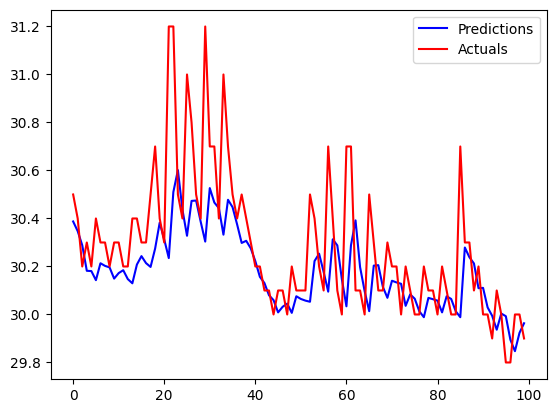

In [81]:
plot_predictions(model1, X1_test, y1_test)

In [82]:
model2 = Sequential()
model2.add(InputLayer((4, 1)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,745 (6.82 KB)

 Trainable params: 1,745 (6.82 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
cp2 = ModelCheckpoint('model2/model2.keras', save_best_only=True, verbose=0)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [84]:
model2.fit(X1_train, y1_train, epochs=10, validation_data=(X1_val, y1_val), callbacks=[cp2])

Epoch 1/10


634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 214.8863 - root_mean_squared_error: 14.1820 - val_loss: 0.1077 - val_root_mean_squared_error: 0.3282
Epoch 2/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1435 - root_mean_squared_error: 0.3784 - val_loss: 0.0989 - val_root_mean_squared_error: 0.3145
Epoch 3/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1313 - root_mean_squared_error: 0.3623 - val_loss: 0.0982 - val_root_mean_squared_error: 0.3134
Epoch 4/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1337 - root_mean_squared_error: 0.3654 - val_loss: 0.0977 - val_root_mean_squared_error: 0.3127
Epoch 5/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1359 - root_mean_squared_error: 0.3683 - val_loss: 0.0976 - val_root_mean_squared_error: 0.3125
Epoch 6/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1268 - root_mean_squared_error: 0.3560 - val_loss: 0.0935 - val_root_mean_squared_error: 0.3058
Epoch 7/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 

 1/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


(      Predictions  Actuals
 0       30.605587     30.5
 1       30.574940     30.4
 2       30.478136     30.2
 3       30.383234     30.3
 4       30.325493     30.2
 ...           ...      ...
 2890    27.833530     27.6
 2891    27.762215     27.6
 2892    27.658812     27.4
 2893    27.544186     27.4
 2894    27.493053     27.4
 
 [2895 rows x 2 columns],
 0.06110770227919669)

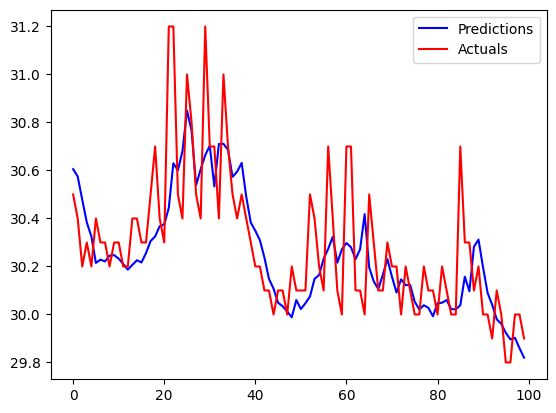

In [85]:
plot_predictions(model2, X1_test, y1_test)

In [88]:
model3 = Sequential()
model3.add(InputLayer((4, 1)))
model3.add(GRU(64))
model3.add(Flatten())
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,393 (52.32 KB)

 Trainable params: 13,393 (52.32 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
cp3 = ModelCheckpoint('model3/model3.keras', save_best_only=True, verbose=0)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model3.fit(X1_train, y1_train, epochs=10, validation_data=(X1_val, y1_val), callbacks=[cp3])

Epoch 1/10


634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 517.2003 - root_mean_squared_error: 22.6613 - val_loss: 174.3403 - val_root_mean_squared_error: 13.2007
Epoch 2/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 114.2227 - root_mean_squared_error: 10.6308 - val_loss: 34.2020 - val_root_mean_squared_error: 5.8453
Epoch 3/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 20.4580 - root_mean_squared_error: 4.5035 - val_loss: 10.8884 - val_root_mean_squared_error: 3.2977
Epoch 4/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.4812 - root_mean_squared_error: 2.9118 - val_loss: 8.3090 - val_root_mean_squared_error: 2.8809
Epoch 5/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.5337 - root_mean_squared_error: 2.3462 - val_loss: 2.2576 - val_root_mean_squared_error: 1.5010
Epoch 6/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0690 - root_mean_squared_error: 1.0259 - val_loss: 0.4633 - val_root_mean_squared_error: 0.6796
Epoch 7/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(      Predictions  Actuals
 0       30.234285     30.5
 1       30.196016     30.4
 2       30.150709     30.2
 3       30.059229     30.3
 4       30.085249     30.2
 ...           ...      ...
 2890    27.683929     27.6
 2891    27.576719     27.6
 2892    27.539507     27.4
 2893    27.405172     27.4
 2894    27.338669     27.4
 
 [2895 rows x 2 columns],
 0.07253168702000723)

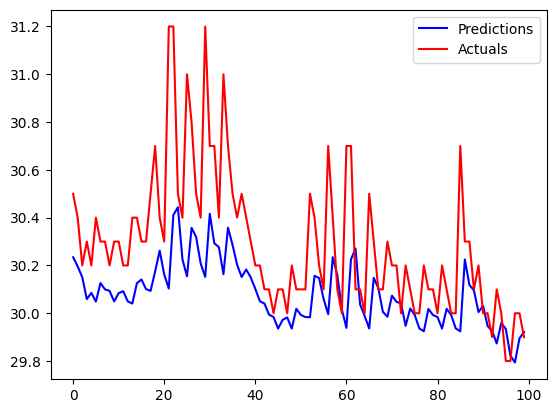

In [90]:
plot_predictions(model3, X1_test, y1_test)

### Conv1D > GRU > LSTM - because of parameter size

# Multivariate Section

### Need to see df without scrolling up

In [91]:
df

,wind dir (deg),wind spd (m/s),wind gst (m/s),wave hgt (ft),mean wave dir (deg),air pres (ft),air temp (deg fah),water temp (deg fah)
timestamp,,,,,,,,
1994-08-17 18:00:00-05:00,185.0,6.0,7.6,0.50,168.0,1016.5,29.7,29.7
1994-08-18 00:00:00-05:00,325.0,0.7,1.3,0.60,128.0,1015.1,30.7,29.9
1994-08-18 06:00:00-05:00,132.0,7.1,8.8,0.80,73.0,1016.4,28.6,29.7
1994-08-18 12:00:00-05:00,180.0,6.0,7.1,1.10,153.0,1016.1,29.0,29.3
1995-02-01 06:00:00-05:00,159.0,4.6,6.1,0.40,17.0,1020.2,17.5,23.0
...,...,...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,8.0,6.4,9.9,1.51,18.0,1022.7,19.6,27.6
2022-10-20 06:40:00-05:00,9.0,4.0,6.6,1.07,56.0,1022.3,19.7,27.6
2022-10-20 12:40:00-05:00,11.0,3.9,6.2,0.93,63.0,1020.7,20.3,27.4


### We should make the timestamp column relative in a unit of time. We need this to make sin and cos curves

In [92]:
def get_relative_minutes(df):
    min_df = df.copy()
    min_df['minutes'] = min_df.index.map(lambda x: x.timestamp() / 60)
    return min_df
df = get_relative_minutes(df)
df

,wind dir (deg),wind spd (m/s),wind gst (m/s),wave hgt (ft),mean wave dir (deg),air pres (ft),air temp (deg fah),water temp (deg fah),minutes
timestamp,,,,,,,,,
1994-08-17 18:00:00-05:00,185.0,6.0,7.6,0.50,168.0,1016.5,29.7,29.7,12952740.0
1994-08-18 00:00:00-05:00,325.0,0.7,1.3,0.60,128.0,1015.1,30.7,29.9,12953100.0
1994-08-18 06:00:00-05:00,132.0,7.1,8.8,0.80,73.0,1016.4,28.6,29.7,12953460.0
1994-08-18 12:00:00-05:00,180.0,6.0,7.1,1.10,153.0,1016.1,29.0,29.3,12953820.0
1995-02-01 06:00:00-05:00,159.0,4.6,6.1,0.40,17.0,1020.2,17.5,23.0,13193940.0
...,...,...,...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,8.0,6.4,9.9,1.51,18.0,1022.7,19.6,27.6,27770740.0
2022-10-20 06:40:00-05:00,9.0,4.0,6.6,1.07,56.0,1022.3,19.7,27.6,27771100.0
2022-10-20 12:40:00-05:00,11.0,3.9,6.2,0.93,63.0,1020.7,20.3,27.4,27771460.0


In [93]:
day = 60*24
year = 365.2425*day
df['Day sin'] = np.sin(df['minutes'] * (2 * np.pi / day))
df['Day cos'] = np.cos(df['minutes'] * (2 * np.pi / day))
df['Year sin'] = np.sin(df['minutes'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['minutes'] * (2 * np.pi / year))
df

,wind dir (deg),wind spd (m/s),wind gst (m/s),wave hgt (ft),mean wave dir (deg),air pres (ft),air temp (deg fah),water temp (deg fah),minutes,Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,
1994-08-17 18:00:00-05:00,185.0,6.0,7.6,0.50,168.0,1016.5,29.7,29.7,12952740.0,-0.258819,0.965926,-0.717511,-0.696547
1994-08-18 00:00:00-05:00,325.0,0.7,1.3,0.60,128.0,1015.1,30.7,29.9,12953100.0,0.965926,0.258819,-0.720500,-0.693454
1994-08-18 06:00:00-05:00,132.0,7.1,8.8,0.80,73.0,1016.4,28.6,29.7,12953460.0,0.258819,-0.965926,-0.723476,-0.690349
1994-08-18 12:00:00-05:00,180.0,6.0,7.1,1.10,153.0,1016.1,29.0,29.3,12953820.0,-0.965926,-0.258819,-0.726438,-0.687232
1995-02-01 06:00:00-05:00,159.0,4.6,6.1,0.40,17.0,1020.2,17.5,23.0,13193940.0,0.258819,-0.965926,0.514218,0.857660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,8.0,6.4,9.9,1.51,18.0,1022.7,19.6,27.6,27770740.0,0.996195,0.087156,-0.948733,0.316078
2022-10-20 06:40:00-05:00,9.0,4.0,6.6,1.07,56.0,1022.3,19.7,27.6,27771100.0,0.087156,-0.996195,-0.947365,0.320155
2022-10-20 12:40:00-05:00,11.0,3.9,6.2,0.93,63.0,1020.7,20.3,27.4,27771460.0,-0.996195,-0.087156,-0.945979,0.324227


### we can remove the minutes column now that we have periodic values sin and cos

In [94]:
df = df.drop(['minutes'], axis=1)

In [95]:
def prediction_2(df, window=4):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range (len(df_as_np) - window):
        row = [a for a in df_as_np[i:i+window]]
        X.append(row)
        label = df_as_np[i+window][0]
        y.append(label)
    return np.array(X), np.array(y)

In [96]:
df2 = df.loc[:, ['water temp (deg fah)', 'Day sin', 'Day cos', 'Year sin', 'Year cos']]
df2

,water temp (deg fah),Day sin,Day cos,Year sin,Year cos
timestamp,,,,,
1994-08-17 18:00:00-05:00,29.7,-0.258819,0.965926,-0.717511,-0.696547
1994-08-18 00:00:00-05:00,29.9,0.965926,0.258819,-0.720500,-0.693454
1994-08-18 06:00:00-05:00,29.7,0.258819,-0.965926,-0.723476,-0.690349
1994-08-18 12:00:00-05:00,29.3,-0.965926,-0.258819,-0.726438,-0.687232
1995-02-01 06:00:00-05:00,23.0,0.258819,-0.965926,0.514218,0.857660
...,...,...,...,...,...
2022-10-20 00:40:00-05:00,27.6,0.996195,0.087156,-0.948733,0.316078
2022-10-20 06:40:00-05:00,27.6,0.087156,-0.996195,-0.947365,0.320155
2022-10-20 12:40:00-05:00,27.4,-0.996195,-0.087156,-0.945979,0.324227


In [97]:
X2, y2 = prediction_2(df2)
X2.shape, y2.shape


((28943, 4, 5), (28943,))

In [98]:
X2_train, y2_train = X2[:int(0.7*len(X2))], y2[:int(0.7*len(y2))] #first 80 for train
X2_val, y2_val = X2[int(0.7*len(X2)):int(0.9*len(X2))], y2[int(0.7*len(y2)):int(0.9*len(y2))] #70 to 90 for validation
X2_test, y2_test = X2[int(0.9*len(X2)):], y2[int(0.9*len(y2)):] #last 10 for test

### Bring water temp into the same scale as the sin and cos values

In [99]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
    return X


In [100]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 1.51388861, -0.99904822, -0.04361939, -0.77166725,
         -0.63602646],
        [ 1.58481004, -0.04361939,  0.99904822, -0.77439546,
         -0.63270188],
        [ 1.51388861,  0.99904822,  0.04361939, -0.77710935,
         -0.6293656 ],
        [ 1.51388861,  0.04361939, -0.99904822, -0.77980886,
         -0.62601768]],

       [[ 1.58481004, -0.04361939,  0.99904822, -0.77439546,
         -0.63270188],
        [ 1.51388861,  0.99904822,  0.04361939, -0.77710935,
         -0.6293656 ],
        [ 1.51388861,  0.04361939, -0.99904822, -0.77980886,
         -0.62601768],
        [ 1.47842789, -0.99904822, -0.04361939, -0.78249395,
         -0.62265819]],

       [[ 1.51388861,  0.99904822,  0.04361939, -0.77710935,
         -0.6293656 ],
        [ 1.51388861,  0.04361939, -0.99904822, -0.77980886,
         -0.62601768],
        [ 1.47842789, -0.99904822, -0.04361939, -0.78249395,
         -0.62265819],
        [ 1.44296717, -0.04361939,  0.99904822, -0.78516457,
         -0

In [101]:
model4 = Sequential()
model4.add(InputLayer((4, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))
model4.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
cp4 = ModelCheckpoint('model4/model4.keras', save_best_only=True, verbose=0)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model4.fit(X2_train, y2_train, epochs=20, validation_data=(X2_val, y2_val), callbacks=[cp4])

Epoch 1/20


634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 668.6605 - root_mean_squared_error: 25.8529 - val_loss: 410.0600 - val_root_mean_squared_error: 20.2463
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 272.6438 - root_mean_squared_error: 16.3826 - val_loss: 4.9683 - val_root_mean_squared_error: 2.2282
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.9063 - root_mean_squared_error: 1.3643 - val_loss: 0.9480 - val_root_mean_squared_error: 0.9731
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7207 - root_mean_squared_error: 0.8485 - val_loss: 0.6971 - val_root_mean_squared_error: 0.8344
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5159 - root_mean_squared_error: 0.7179 - val_loss: 0.5086 - val_root_mean_squared_error: 0.7127
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3783 - root_mean_squared_error: 0.6148 - val_loss: 0.3802 - val_root_mean_squared_error: 0.6162
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - 

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(      Predictions  Actuals
 0       30.360807     30.5
 1       30.712484     30.4
 2       30.646544     30.2
 3       30.264229     30.3
 4       30.190527     30.2
 ...           ...      ...
 2890    27.914869     27.6
 2891    27.724930     27.6
 2892    27.584009     27.4
 2893    27.654638     27.4
 2894    27.607895     27.4
 
 [2895 rows x 2 columns],
 0.06434356081254756)

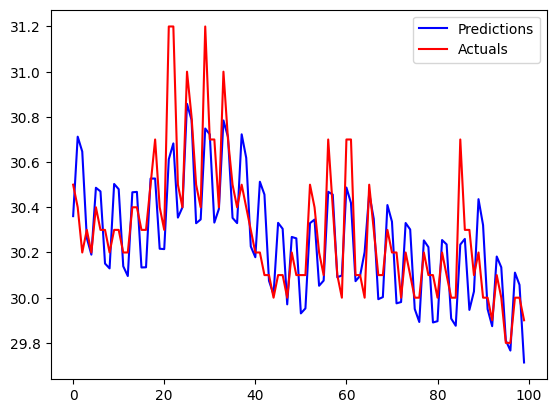

In [103]:
plot_predictions(model4, X2_test, y2_test)

In [104]:
df

,wind dir (deg),wind spd (m/s),wind gst (m/s),wave hgt (ft),mean wave dir (deg),air pres (ft),air temp (deg fah),water temp (deg fah),Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,
1994-08-17 18:00:00-05:00,185.0,6.0,7.6,0.50,168.0,1016.5,29.7,29.7,-0.258819,0.965926,-0.717511,-0.696547
1994-08-18 00:00:00-05:00,325.0,0.7,1.3,0.60,128.0,1015.1,30.7,29.9,0.965926,0.258819,-0.720500,-0.693454
1994-08-18 06:00:00-05:00,132.0,7.1,8.8,0.80,73.0,1016.4,28.6,29.7,0.258819,-0.965926,-0.723476,-0.690349
1994-08-18 12:00:00-05:00,180.0,6.0,7.1,1.10,153.0,1016.1,29.0,29.3,-0.965926,-0.258819,-0.726438,-0.687232
1995-02-01 06:00:00-05:00,159.0,4.6,6.1,0.40,17.0,1020.2,17.5,23.0,0.258819,-0.965926,0.514218,0.857660
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,8.0,6.4,9.9,1.51,18.0,1022.7,19.6,27.6,0.996195,0.087156,-0.948733,0.316078
2022-10-20 06:40:00-05:00,9.0,4.0,6.6,1.07,56.0,1022.3,19.7,27.6,0.087156,-0.996195,-0.947365,0.320155
2022-10-20 12:40:00-05:00,11.0,3.9,6.2,0.93,63.0,1020.7,20.3,27.4,-0.996195,-0.087156,-0.945979,0.324227


### Add another predictive variable

In [105]:
def prediction_two_var(df, window=4):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range (len(df_as_np) - window):
        row = [a for a in df_as_np[i:i+window]]
        X.append(row)
        label = [df_as_np[i+window][0], df_as_np[i+window][1]]
        y.append(label)
    return np.array(X), np.array(y)

In [106]:
df3 = df.loc[:, ['wave hgt (ft)', 'water temp (deg fah)', 'Day sin', 'Day cos', 'Year sin', 'Year cos', ]]

In [107]:
df3

,wave hgt (ft),water temp (deg fah),Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,
1994-08-17 18:00:00-05:00,0.50,29.7,-0.258819,0.965926,-0.717511,-0.696547
1994-08-18 00:00:00-05:00,0.60,29.9,0.965926,0.258819,-0.720500,-0.693454
1994-08-18 06:00:00-05:00,0.80,29.7,0.258819,-0.965926,-0.723476,-0.690349
1994-08-18 12:00:00-05:00,1.10,29.3,-0.965926,-0.258819,-0.726438,-0.687232
1995-02-01 06:00:00-05:00,0.40,23.0,0.258819,-0.965926,0.514218,0.857660
...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,1.51,27.6,0.996195,0.087156,-0.948733,0.316078
2022-10-20 06:40:00-05:00,1.07,27.6,0.087156,-0.996195,-0.947365,0.320155
2022-10-20 12:40:00-05:00,0.93,27.4,-0.996195,-0.087156,-0.945979,0.324227


In [108]:
X3, y3 = prediction_two_var(df3)
X3.shape, y3.shape

((28943, 4, 6), (28943, 2))

In [109]:
X3_train, y3_train = X3[:int(0.7*len(X3))], y3[:int(0.7*len(y3))] #first 80 for train
X3_val, y3_val = X3[int(0.7*len(X3)):int(0.9*len(X3))], y3[int(0.7*len(y3)):int(0.9*len(y3))] #70 to 90 for validation
X3_test, y3_test = X3[int(0.9*len(X3)):], y3[int(0.9*len(y3)):] #last 10 for test

In [110]:
wave_hgt_training_mean = np.mean(X3_train[:, :, 0])
wave_hgt_training_std = np.std(X3_train[:, :, 0])
temp_training_mean = np.mean(X3_train[:, :, 1])
temp_training_std = np.std(X3_train[:, :, 1])

def preprocess_input(X):
    X[:, :, 0] = (X[:, :, 0] - wave_hgt_training_mean) / wave_hgt_training_std
    X[:, :, 1] = (X[:, :, 1] - temp_training_mean) / temp_training_std
    
    return X

def preprocess_output(y):
    y[:, 0] = (y[:, 0] - wave_hgt_training_mean) / wave_hgt_training_std
    y[:, 1] = (y[:, 1] - temp_training_mean) / temp_training_std
    return y

In [111]:
preprocess_input(X3_train)
preprocess_input(X3_val)
preprocess_input(X3_test)
preprocess_output(y3_train)
preprocess_output(y3_val)
preprocess_output(y3_test)

array([[-0.24767699,  1.47842789],
       [ 0.60583599,  1.44296717],
       [-0.12174884,  1.37204574],
       ...,
       [-0.47154924,  0.37914568],
       [-0.80735763,  0.37914568],
       [-1.11518198,  0.37914568]])

In [112]:
model5 = Sequential()
model5.add(InputLayer((4, 6)))
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(2, 'linear'))
model5.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,714 (73.10 KB)

 Trainable params: 18,714 (73.10 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
cp5 = ModelCheckpoint('model5/model5.keras', save_best_only=True, verbose=0)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model5.fit(X3_train, y3_train, epochs=10, validation_data=(X3_val, y3_val), callbacks=[cp5])

Epoch 1/10


634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7386 - root_mean_squared_error: 0.8553 - val_loss: 0.2189 - val_root_mean_squared_error: 0.4680
Epoch 2/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2367 - root_mean_squared_error: 0.4863 - val_loss: 0.1696 - val_root_mean_squared_error: 0.4119
Epoch 3/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1846 - root_mean_squared_error: 0.4295 - val_loss: 0.1286 - val_root_mean_squared_error: 0.3587
Epoch 4/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1381 - root_mean_squared_error: 0.3716 - val_loss: 0.0960 - val_root_mean_squared_error: 0.3099
Epoch 5/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1160 - root_mean_squared_error: 0.3405 - val_loss: 0.0881 - val_root_mean_squared_error: 0.2969
Epoch 6/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1082 - root_mean_squared_error: 0.3288 - val_loss: 0.0850 - val_root_mean_squared_error: 0.2917
Epoch 7/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1

In [114]:
def postprocess_wave(arr):
    arr = (arr*wave_hgt_training_std) + wave_hgt_training_mean
    return arr
def postprocess_temp(arr):
    arr = (arr*temp_training_std) + temp_training_mean
    return arr

In [115]:
def plot_all_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X)
    wv_preds, temp_preds = postprocess_wave(predictions[:, 0]), postprocess_temp(predictions[:, 1])
    wv_actuals, temp_actuals = postprocess_wave(y[:, 0]), postprocess_temp(y[:, 1])
    df = pd.DataFrame(data ={'Wave Height Predictions': wv_preds, 'Wave Height Actuals': wv_actuals, 'Temp Predictions': temp_preds, 'Temp Actuals': temp_actuals})
    plt.plot(df['Wave Height Predictions'][start:end], color='blue', label='Wave Height Predictions')
    plt.plot(df['Wave Height Actuals'][start:end], color='red', label='Wave Height Actuals')
    plt.plot(df['Temp Predictions'][start:end], color='green', label='Temp Predictions')
    plt.plot(df['Temp Actuals'][start:end], color='orange', label='Temp Actuals')
    return df[start:end]

 1/91 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


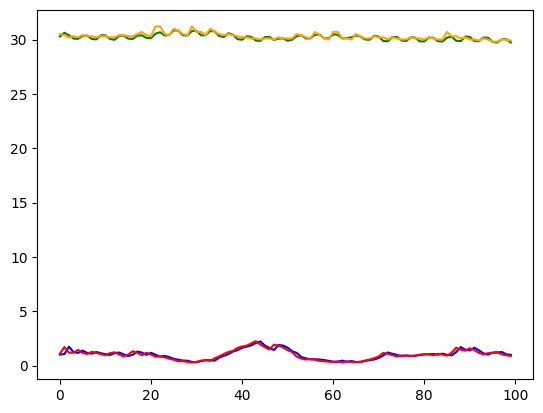

In [116]:
post_processed_df = plot_all_predictions(model5, X3_test, y3_test)

In [119]:
model6 = Sequential()
model6.add(InputLayer((4, 6)))
model6.add(LSTM(32, return_sequences=True))
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(2, 'linear'))
model6.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 4, 32)          │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,362 (118.60 KB)

 Trainable params: 30,362 (118.60 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
cp6 = ModelCheckpoint('model6/model6.keras', save_best_only=True, verbose=0)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model6.fit(X3_train, y3_train, epochs=10, validation_data=(X3_val, y3_val), callbacks=[cp6])

Epoch 1/10


634/634 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8073 - root_mean_squared_error: 0.8966 - val_loss: 0.3074 - val_root_mean_squared_error: 0.5546
Epoch 2/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3156 - root_mean_squared_error: 0.5610 - val_loss: 0.2053 - val_root_mean_squared_error: 0.4532
Epoch 3/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2253 - root_mean_squared_error: 0.4745 - val_loss: 0.1424 - val_root_mean_squared_error: 0.3774
Epoch 4/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1522 - root_mean_squared_error: 0.3901 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3371
Epoch 5/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1332 - root_mean_squared_error: 0.3649 - val_loss: 0.1000 - val_root_mean_squared_error: 0.3162
Epoch 6/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1187 - root_mean_squared_error: 0.3445 - val_loss: 0.0903 - val_root_mean_squared_error: 0.3006
Epoch 7/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


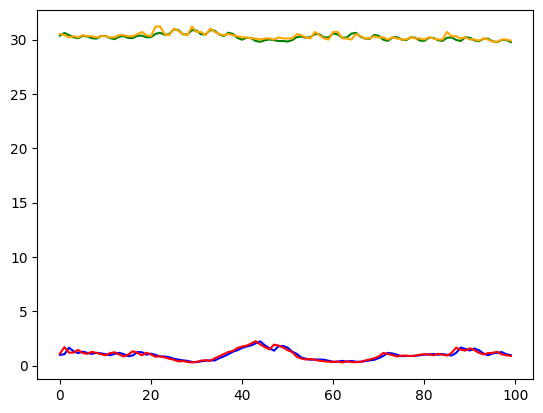

In [121]:
post_processed_df = plot_all_predictions(model6, X3_test, y3_test)

In [123]:
model7 = Sequential()
model7.add(InputLayer((4, 6)))
model7.add(Conv1D(64, kernel_size=2, activation='relu'))
model7.add(Flatten())
model7.add(Dense(8, 'relu'))
model7.add(Dense(2, 'linear'))
model7.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 3, 64)          │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │         1,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,394 (9.35 KB)

 Trainable params: 2,394 (9.35 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
cp7 = ModelCheckpoint('model7/model7.keras', save_best_only=True, verbose=0)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model7.fit(X3_train, y3_train, epochs=10, validation_data=(X3_val, y3_val), callbacks=[cp7])

Epoch 1/10


634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7511 - root_mean_squared_error: 0.8606 - val_loss: 0.2326 - val_root_mean_squared_error: 0.4822
Epoch 2/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1971 - root_mean_squared_error: 0.4434 - val_loss: 0.1161 - val_root_mean_squared_error: 0.3408
Epoch 3/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1380 - root_mean_squared_error: 0.3713 - val_loss: 0.0957 - val_root_mean_squared_error: 0.3094
Epoch 4/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1209 - root_mean_squared_error: 0.3474 - val_loss: 0.0884 - val_root_mean_squared_error: 0.2974
Epoch 5/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1044 - root_mean_squared_error: 0.3230 - val_loss: 0.0843 - val_root_mean_squared_error: 0.2904
Epoch 6/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1044 - root_mean_squared_error: 0.3229 - val_loss: 0.0824 - val_root_mean_squared_error: 0.2870
Epoch 7/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1

 1/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


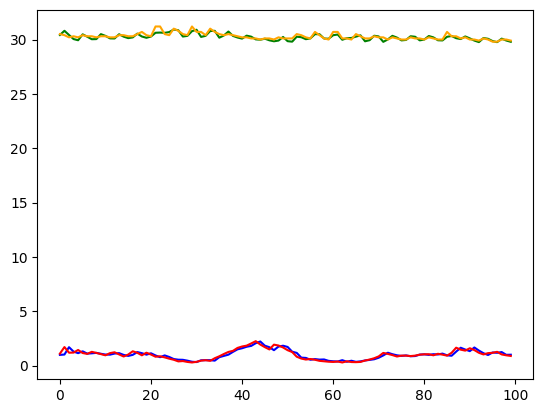

In [126]:
post_processed_df = plot_all_predictions(model7, X3_test, y3_test)